In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

**Part 1: Introduction**

My project aims to complete a classification task using NBA player statistics to predict whether a player is an MVP based on their performance across a given year. Specifically, the dataset consists of detailed player statistics such as points, rebounds, assists, shooting percentages (e.g.,field goal percentage, three-point percentage, free throw percentage), and
other relevant metrics for the top  players in the NBA every year from 1982 to 2022. The data set that I am using has already identified the top  players in each year and I will add a binary column indicating whether someone was the MVP in a given year or not. My goal is to use these features to classify players as MVPs or not for each respective year. I will train and test multiple predictive models to assess which approach best predicts MVP performance, including using a Logistic Regressor as well as the Random Forest Regressor. I will also explore using a model that we have not learned in class yet: XGBoost (Gradient Boosting). I will separate the data set to be from 1982 to 2002 as a train period and then I will test from 2002 to 2022. This dataset is from Kaggle and was scraped from basketballreference.com. Attached is the link to where I retrieved the dataset: https://www.kaggle.com/code/robertsunderhaft/predicting-the-nba-mvp.

To summarize my findings, which I will display shortly, I found that all 3 classifiers work exceptionally well to determine whether a player is an MVP or not, with all 3 having a test score of >0.99. I found that the XGBoost Classifier and Linear Regressor typically marginally outperform the Random Forest Classifier. This is likely as a result of the simplicity of the task and the "ease" for these classifiers to take this relatively large amount of data to predict an MVP award that is typically based on these factors. I believe the XGBoost and Linear Regressor outperform because they are inherently less likely to overfit, whereas the Random Forest is more prone to overfitting, which is why it performs relatively worse.

**Part 2: Data Description & Exploration**

*Note: the columns in the data set change as I work through the task, as certain columns are used for certain tasks and then not included for other tasks. As a result, if you are running the code to test the models, make sure to run from the top to the bottom, but skipping any previous model code cells, in order to make sure that you are using the intended data set for the model.*

This dataset is from Kaggle and was scraped from basketballreference.com. Attached is the link to where I retrieved the dataset: https://www.kaggle.com/code/robertsunderhaft/predicting-the-nba-mvp. The dataset has 56 columns and 17,696 entries. The dataset consists of detailed player statistics such as points, rebounds, assists, shooting percentages (e.g. field goal percentage, three-point percentage, free throw percentage), and
other relevant metrics for the top players in the NBA every year from 1982 to 2022. Additionally, the data set includes a column called “award_share” which represents the share of votes an individual player received for the MVP award each year. The player with the highest award share in a year is the player that won the NBA MVP award. Using this information, I created an “is_mvp” column in the dataset, which tells me whether a player was MVP or not within a given year. This is the column that will be used as the target for my models.

In exploration of the data, I made charts for the number of MVPs that a player won, as well as created correlation matrices for the features in the datasets. As interesting as all of the data is, there were 50+ columns in the data set, some of which are repetitive measures of one's skill within a year (ie. multiple metrics about field goals and multiple metrics about 3 pointers.) As a result, I manually removed some of these more repetitive columns or columns that are not logical to be used. First, I made a correlation matrix with all the columns in the data set. Then, given the high correlation and near-perfect between some features as well as the logical issues with using some of the features (ie mov, mov_adj, and win_loss_pct), I am removing certain columns from the data set that are either illogical or already represented. Additionally, if there is both the made shots per game and shots attempted per game as well as the overall shot % for any given type of shot (ie. 3-pointer or free-throw), I removed the first two and used just the percentage feature for the given shot. I also used code to remove the player and team_id columns.

I then ran a linear regression to explore the absolute coefficients of each remaining feature in predicting NBA MVPs/non-MVPs. This revealed that the win shares per 48 minutes, true shooting percentage, and field goal percentages were the 3 most impactful features in the linear regression.

First, I am loading in the data set and creating the binary MVP column. The dataset already includes "award_share", which is a metric that shows the percentage of MVP votes a player won within a given year. The player that has the maximum award share within a year is the player that was MVP that year, so I used that information to add an MVP column that will be my target for the classification task.

In [17]:
df = pd.read_csv('NBA_Dataset.csv')

df_filtered = df[(df['season'] >= 1982) & (df['season'] <= 2022)]

df_filtered['is_mvp'] = df_filtered.groupby('season')['award_share'].transform('max') == df_filtered['award_share']
df_filtered['is_mvp'] = df_filtered['is_mvp'].astype(int)

df_filtered.head()

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,0
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,0
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,0
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,0
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,0


In [18]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17697 entries, 0 to 17696
Data columns (total 56 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            17697 non-null  int64  
 1   player            17697 non-null  object 
 2   pos               17697 non-null  object 
 3   age               17697 non-null  int64  
 4   team_id           17697 non-null  object 
 5   g                 17697 non-null  int64  
 6   gs                17697 non-null  int64  
 7   mp_per_g          17697 non-null  float64
 8   fg_per_g          17697 non-null  float64
 9   fga_per_g         17697 non-null  float64
 10  fg_pct            17634 non-null  float64
 11  fg3_per_g         17697 non-null  float64
 12  fg3a_per_g        17697 non-null  float64
 13  fg3_pct           15074 non-null  float64
 14  fg2_per_g         17697 non-null  float64
 15  fg2a_per_g        17697 non-null  float64
 16  fg2_pct           17591 non-null  float6

Now, we can sort and look through all of the MVPs from 1982 to 2002, which is shown below.

In [19]:
mvp_players = df_filtered[df_filtered['is_mvp'] == 1]
mvp_players

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,is_mvp
186,1982,Moses Malone,C,26,HOU,81,81,42.0,11.7,22.5,...,0.218,6.2,-1.8,4.5,5.5,0.735,-0.04,-0.39,0.561,1
493,1983,Moses Malone,C,27,PHI,78,78,37.5,8.4,16.7,...,0.248,4.0,-0.3,3.7,4.2,0.960,7.67,7.53,0.793,1
647,1984,Larry Bird,PF,27,BOS,79,77,38.3,9.6,19.5,...,0.215,5.6,2.0,7.6,7.3,0.858,6.56,6.42,0.756,1
957,1985,Larry Bird,SF,28,BOS,80,77,39.5,11.5,22.0,...,0.238,6.8,2.0,8.8,8.7,0.978,6.65,6.47,0.768,1
1278,1986,Larry Bird,SF,29,BOS,82,81,38.0,9.7,19.6,...,0.244,6.6,2.1,8.7,8.4,0.981,9.41,9.06,0.817,1
1719,1987,Magic Johnson,PG,27,LAL,80,80,36.3,8.5,16.4,...,0.263,7.5,1.3,8.8,8.0,0.940,9.30,8.32,0.793,1
2067,1988,Michael Jordan,SG,24,CHI,82,82,40.4,13.0,24.4,...,0.308,8.8,4.2,13.0,12.5,0.831,3.40,3.76,0.610,1
2407,1989,Magic Johnson,PG,29,LAL,77,77,37.5,7.5,14.8,...,0.267,7.3,2.0,9.4,8.3,0.782,7.17,6.38,0.695,1
2767,1990,Magic Johnson,PG,30,LAL,79,79,37.2,6.9,14.4,...,0.270,8.3,1.8,10.1,8.9,0.691,6.78,6.74,0.768,1
3162,1991,Michael Jordan,SG,27,CHI,82,82,37.0,12.1,22.4,...,0.321,8.9,3.2,12.0,10.8,0.928,9.10,8.57,0.744,1


As we can see below, the players with the most MVP awards from 1982 to 2002 are Micheal Jordan, Lebron James, Magic Johnson, and Larry Bird.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

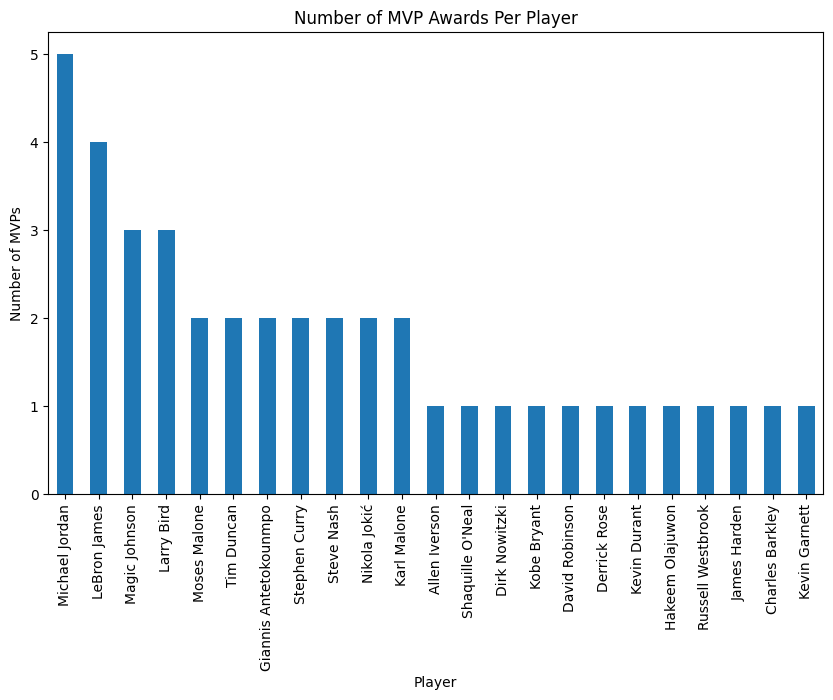

In [20]:
mvp_counts = mvp_players['player'].value_counts()

plt.figure(figsize=(10, 6))
mvp_counts.plot(kind='bar')
plt.xlabel('Player')
plt.ylabel('Number of MVPs')
plt.title('Number of MVP Awards Per Player')
plt

As interesting as all of the data is, there are still 50+ columns in the data set, some of which are repetitive measures of one's skill within a year (ie. multiple metrics about field goals and multiple metrics about 3 pointers.) As a result, I will manually remove some of these more repetitive columns or columns that are not logical to be used.

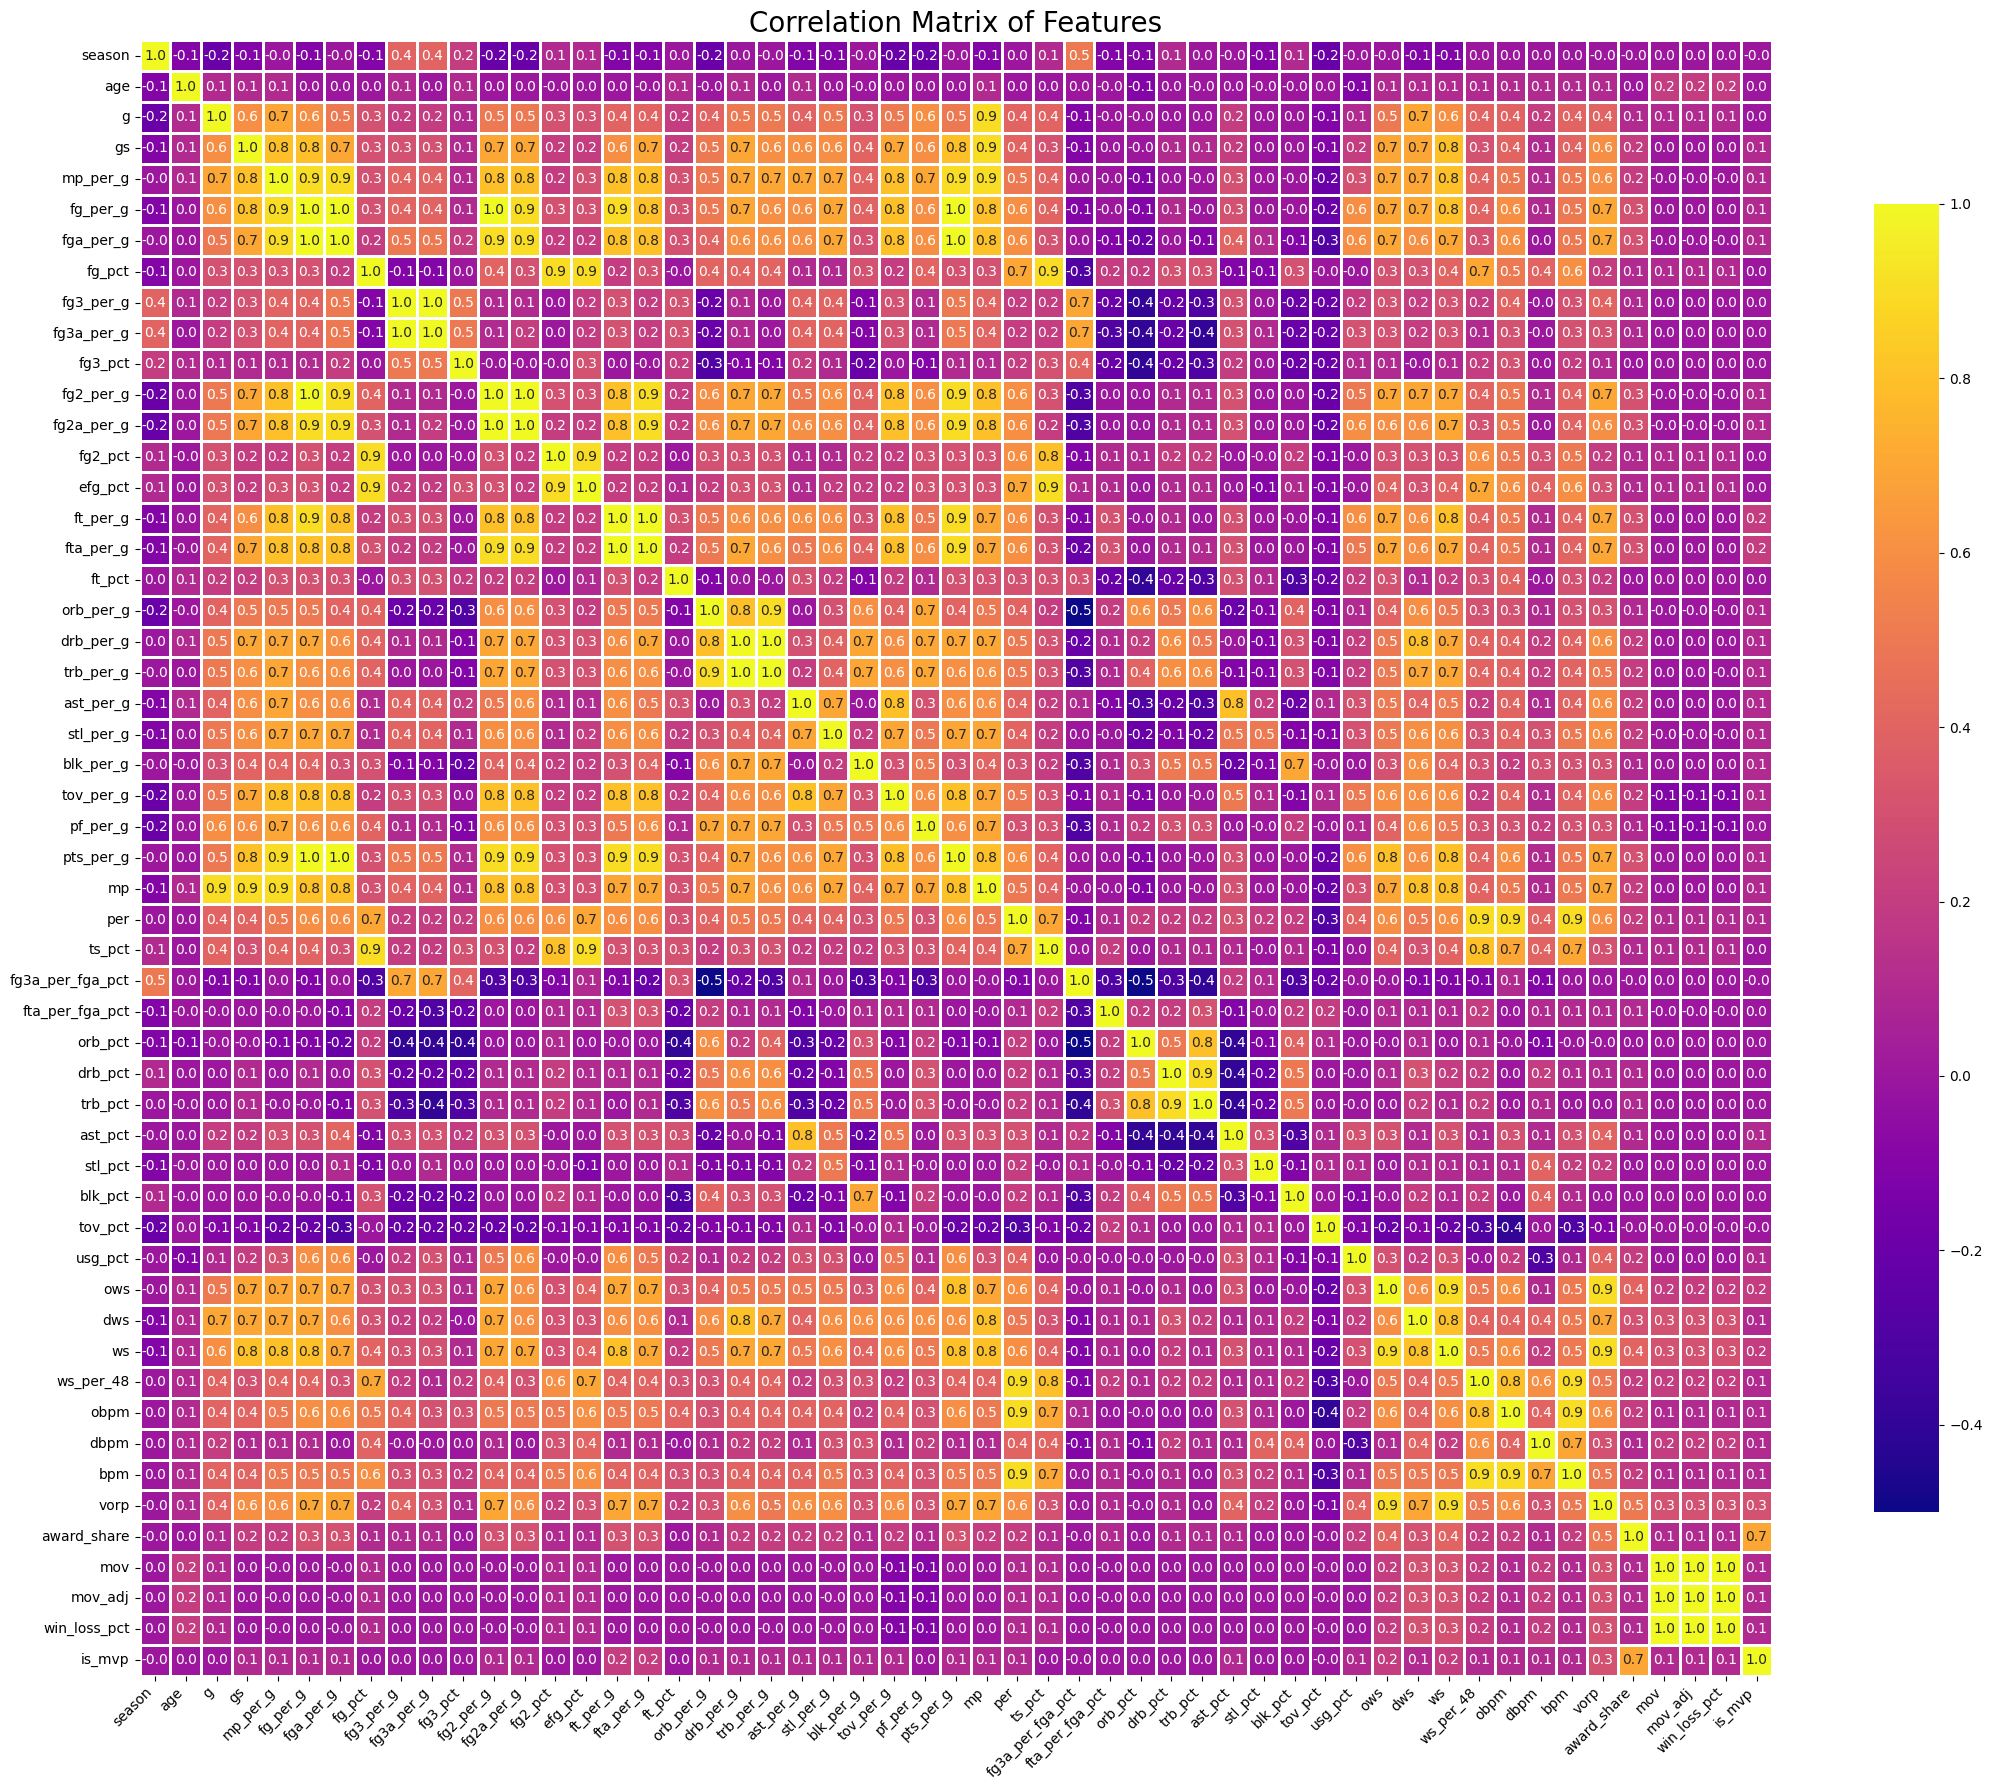

In [9]:
numeric_df = df_filtered.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
correlation_matrix = correlation_matrix.round(1)

plt.figure(figsize=(22, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt='.1f', linewidths=2,
            annot_kws={'size': 10}, cbar_kws={'shrink': 0.8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Matrix of Features', fontsize=20)
plt.tight_layout()
plt.show()

Given the high correlation and near-perfect between some features as well as the logical issues with using some of the features (ie mov, mov_adj, and win_loss_pct), I am removing certain columns from the data set that are either illogical or already represented. Additionally, if there is both the made shots per game and shots attempted per game as well as the overall shot % for any given type of shot (ie. 3-pointer or free-throw), I removed the first two and used just the percentage feature for the given shot. I also used this code to remove non-numeric unimportant features like player and team_id.

In [21]:
df_filtered = df_filtered.drop(columns=['player', 'team_id', 'fg_per_g', 'fga_per_g', 'fg3_per_g', 'fg3a_per_g', 'fg2_per_g', 'fg2a_per_g', 'ft_per_g', 'fta_per_g', 'ws', 'mov', 'mov_adj'])

Now, I will look at the new correlation matrix having excluded those certain features.

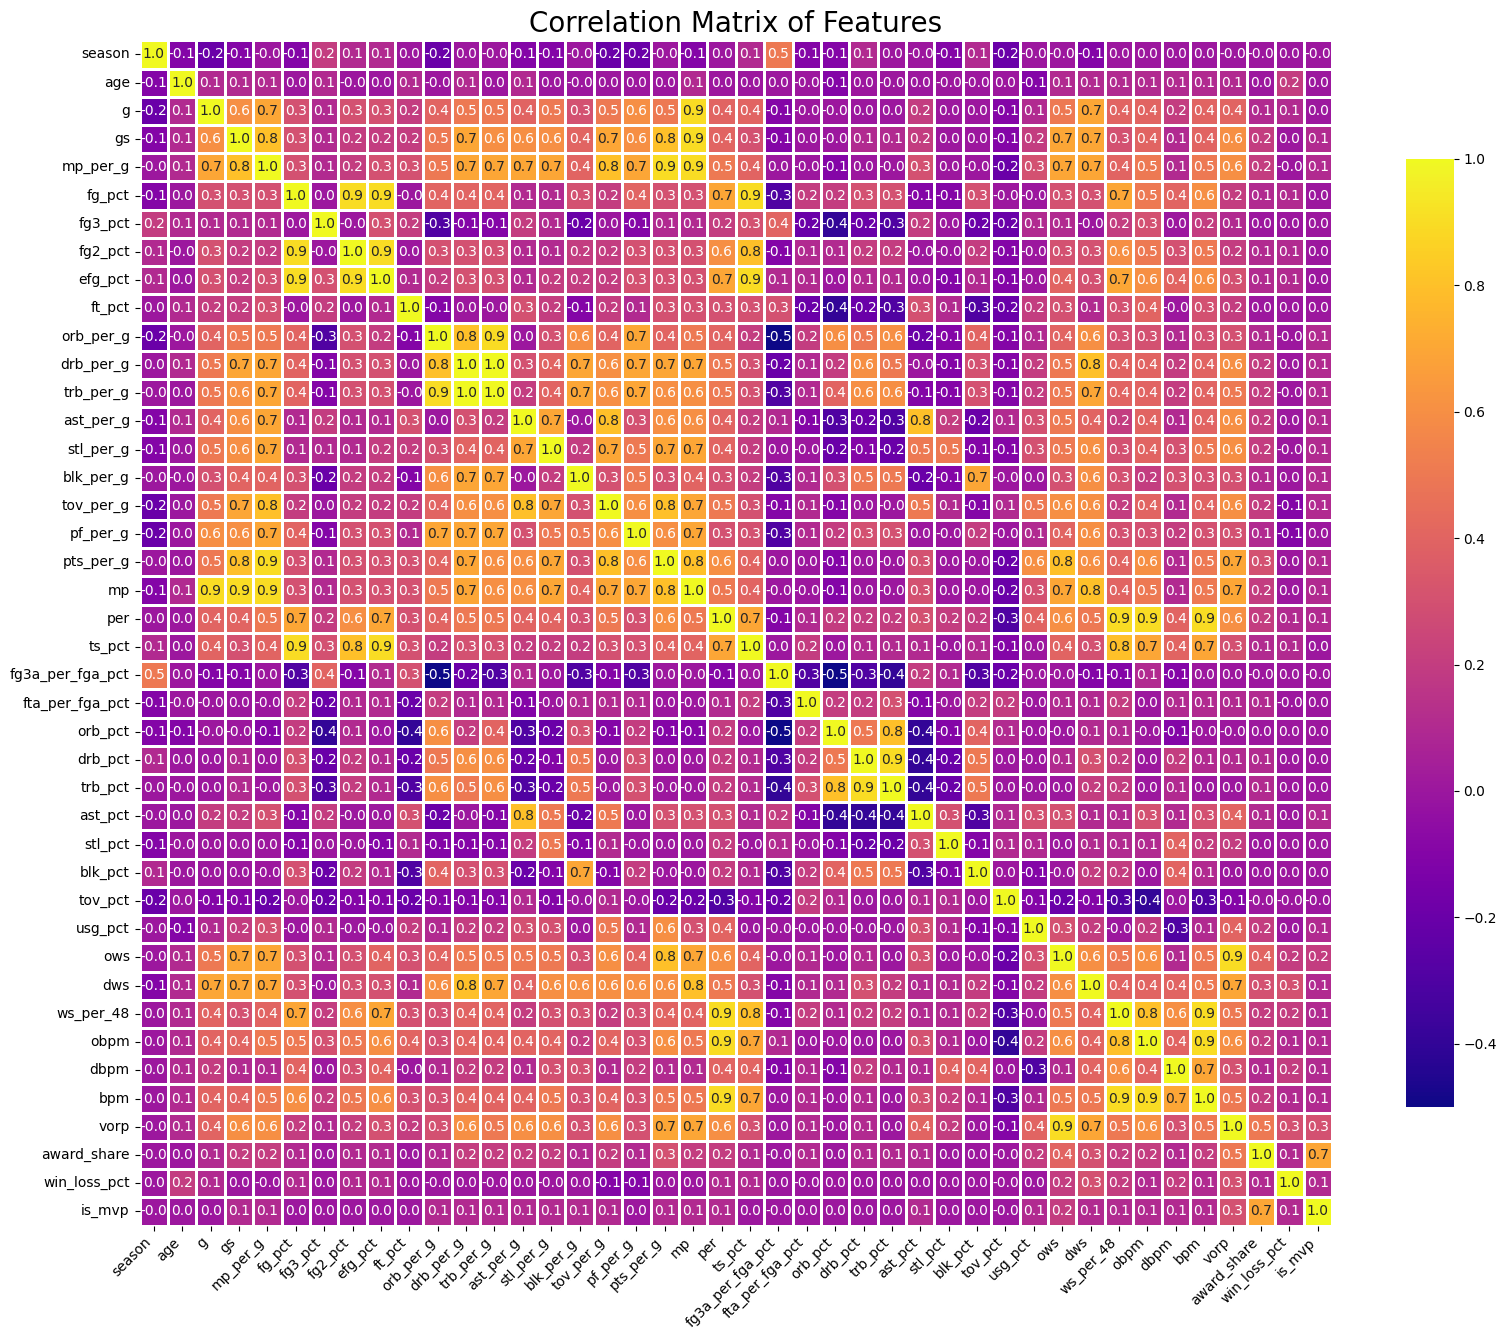

In [11]:
numeric_df = df_filtered.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
correlation_matrix = correlation_matrix.round(1)

plt.figure(figsize=(16.5, 13.5))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt='.1f', linewidths=1,
            annot_kws={'size': 10}, cbar_kws={'shrink': 0.8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Matrix of Features', fontsize=20)
plt.tight_layout()
plt.show()

Now, I am running a linear regression of all numerical features against the actual MVP win to visualize a ranking of features.

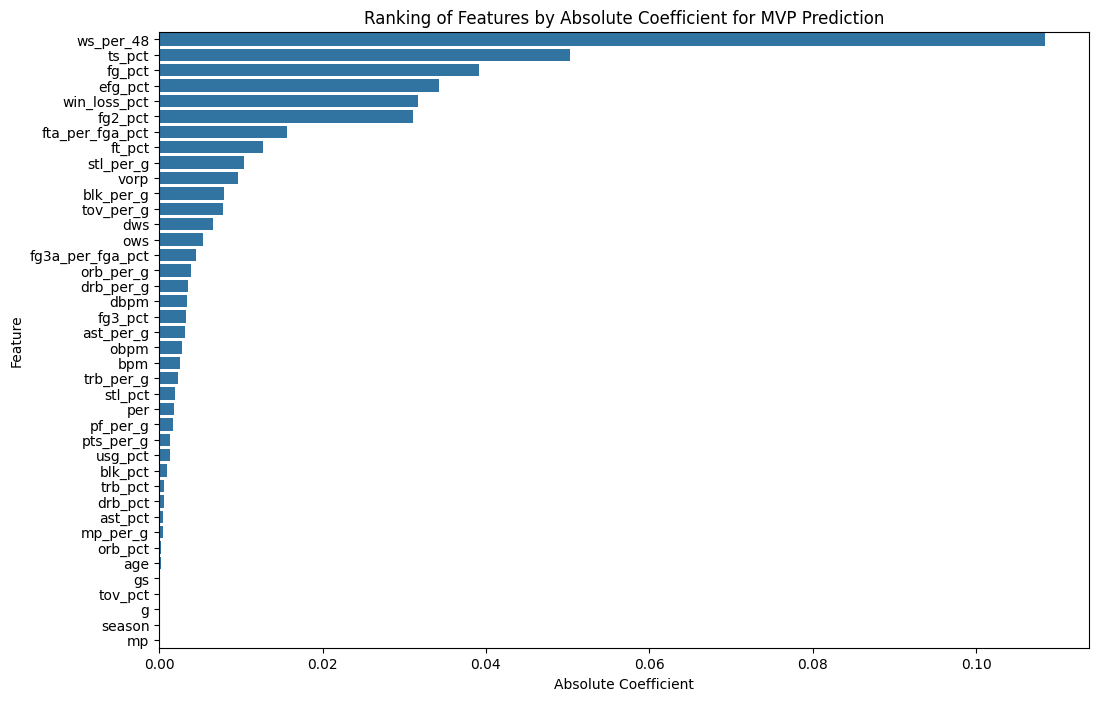

In [22]:
#cleaning data before regression
df = df_filtered.dropna()

#dropping award share and is_mvp as the share of MVP votes will obviously have a strong correlation with MVP win and position because it is non-numerical but still in the data
X = df.drop(columns=['award_share', 'pos', 'is_mvp'])
y = df['is_mvp']

# initalizing the linear regression model
model = LinearRegression()

#storing features and their coefficients from the linear regression
feature_coefficients = []
for feature in X.columns:
      X_feature = X[[feature]].values
      model.fit(X_feature, y)
      feature_coefficients.append({
          'Feature': feature,
          'Coefficient': model.coef_[0]
      })

#taking the absolute value of coefficients and sorting them
if feature_coefficients:
    coef_df = pd.DataFrame(feature_coefficients)
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# plottig the feature importances (absolute value of coefficients)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df_sorted)
    plt.title('Ranking of Features by Absolute Coefficient for MVP Prediction')
    plt.xlabel('Absolute Coefficient')
    plt.ylabel('Feature')
    plt.show()

This reveals that the win shares per 48 minutes, true shooting percentage, and field goal percentages were the 3 most impactful features in the linear regression.

**Part 3: Models and Methods**

 Having finished my exploration of the data, I will now run tests using various classification models on the full dataset, which I have divided into test and train. The following code should allow for the creation of models that use the information from the test data to accurately classify every player in the dataset as either an MVP or not an MVP. The 3 models I'm using are a Logistic regressor, a RandomForest classifier, and an XGBoost classifier. A Logistic regressor is a linear model that predicts the probability of a binary outcome using the logistic (sigmoid) function and assumes the data is linearly separable. A Random Forest Classifier is an ensemble method that combines predictions from multiple randomly built decision trees using majority voting. XGBoost is a boosting algorithm that sequentially builds decision trees to minimize a loss function using gradient descent and regularization.

To clarify my methods, I first filtered the data to only use numeric columns, and these columns are what remain after the previous filtering I did. Additionally, I dropped the "award_share" column, as it reveals the voting share for each player within a year and has already been used to make a binary MVP column. Now, setting the "is_mvp" column as my target, I trained and tested all 3 of my models and plotted their confusion matricies.


Logistic Regression Train Accuracy: 0.99848
Logistic Regression Test Accuracy: 0.99842

Logistic Regression Confusion Matrix:
 [[8192    3]
 [  10   10]]

Random Forest Train Accuracy: 1.00000
Random Forest Test Accuracy: 0.99793

Random Forest Confusion Matrix:
 [[8195    0]
 [  17    3]]

XGBoost Train Accuracy: 1.00000
XGBoost Test Accuracy: 0.99842

XGBoost Confusion Matrix:
 [[8192    3]
 [  10   10]]


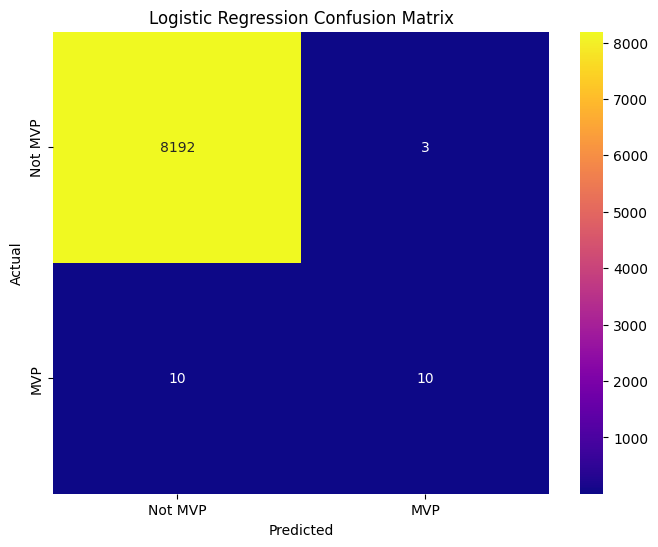

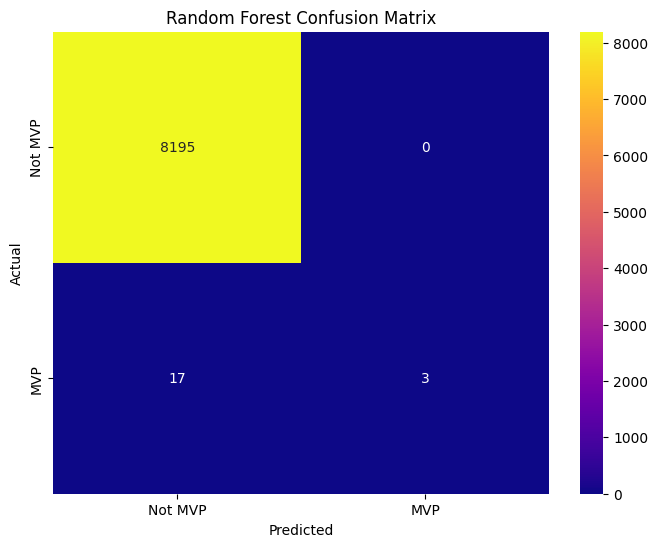

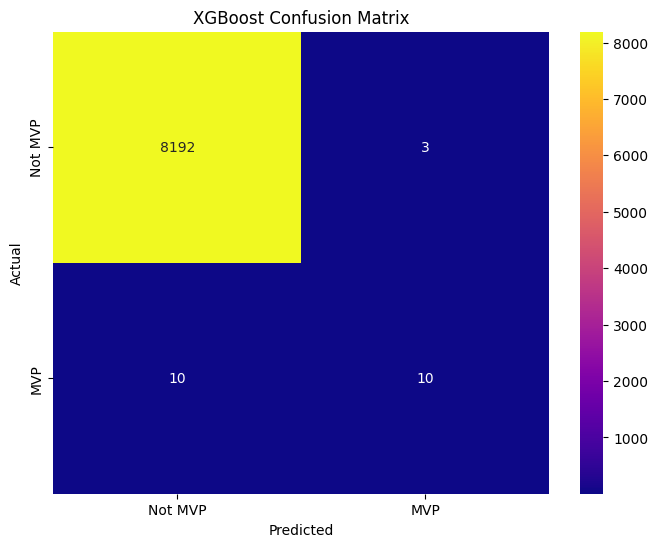

In [13]:
# filtering numeric data and dropping null values
df_filtered = df_filtered.select_dtypes(include=[np.number]).dropna()

# removing the 'award_share' column, as it implicitly defines the is_mvp column
df_filtered = df_filtered.drop(columns=['award_share'])

X = df_filtered.drop(columns=['is_mvp'])

# target variable
y = df_filtered['is_mvp']

# splitting the data into train (1982-2002) and test (2003-2022)
train_df = df_filtered[df_filtered['season'] <= 2002]
test_df = df_filtered[df_filtered['season'] > 2002]

# defining features and target for train and test sets
X_train = train_df.drop(columns=['is_mvp'])
y_train = train_df['is_mvp']
X_test = test_df.drop(columns=['is_mvp'])
y_test = test_df['is_mvp']

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg_test = log_reg.predict(X_test_scaled)
y_pred_log_reg_train = log_reg.predict(X_train_scaled)

# Accuracy Scores
log_reg_train_acc = accuracy_score(y_train, y_pred_log_reg_train)
log_reg_test_acc = accuracy_score(y_test, y_pred_log_reg_test)

print(f"Logistic Regression Train Accuracy: {log_reg_train_acc:.5f}")
print(f"Logistic Regression Test Accuracy: {log_reg_test_acc:.5f}")
print()

# Confusion Matrix
print('Logistic Regression Confusion Matrix:\n', confusion_matrix(y_test, y_pred_log_reg_test))

# 2. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf_test = rf.predict(X_test_scaled)
y_pred_rf_train = rf.predict(X_train_scaled)

# Accuracy Scores
rf_train_acc = accuracy_score(y_train, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf_test)

print()
print(f"Random Forest Train Accuracy: {rf_train_acc:.5f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.5f}")
print()

# Confusion Matrix
print('Random Forest Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf_test))

# 3. XGBoost Classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb_test = xgb_model.predict(X_test_scaled)
y_pred_xgb_train = xgb_model.predict(X_train_scaled)

# Accuracy Scores
xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)

print()
print(f"XGBoost Train Accuracy: {xgb_train_acc:.5f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.5f}")
print()

# Confusion Matrix
print('XGBoost Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb_test))

# Plotting Confusion Matrices
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=['Not MVP', 'MVP'], yticklabels=['Not MVP', 'MVP'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, y_pred_log_reg_test, 'Logistic Regression')
plot_conf_matrix(y_test, y_pred_rf_test, 'Random Forest')
plot_conf_matrix(y_test, y_pred_xgb_test, 'XGBoost')

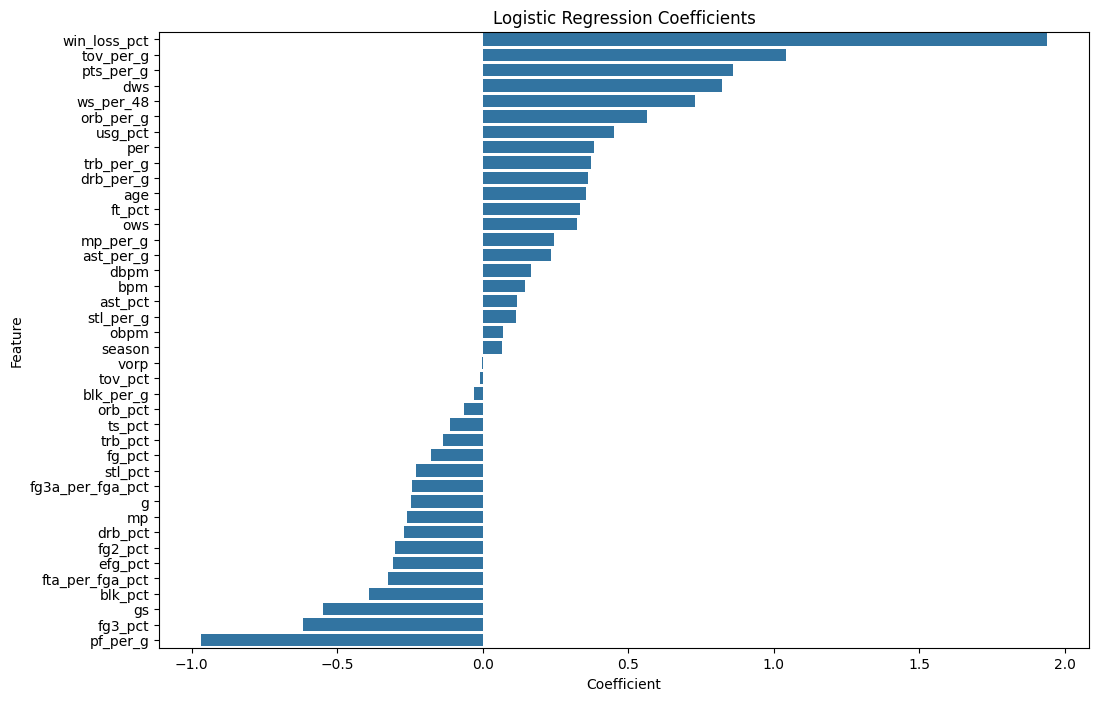

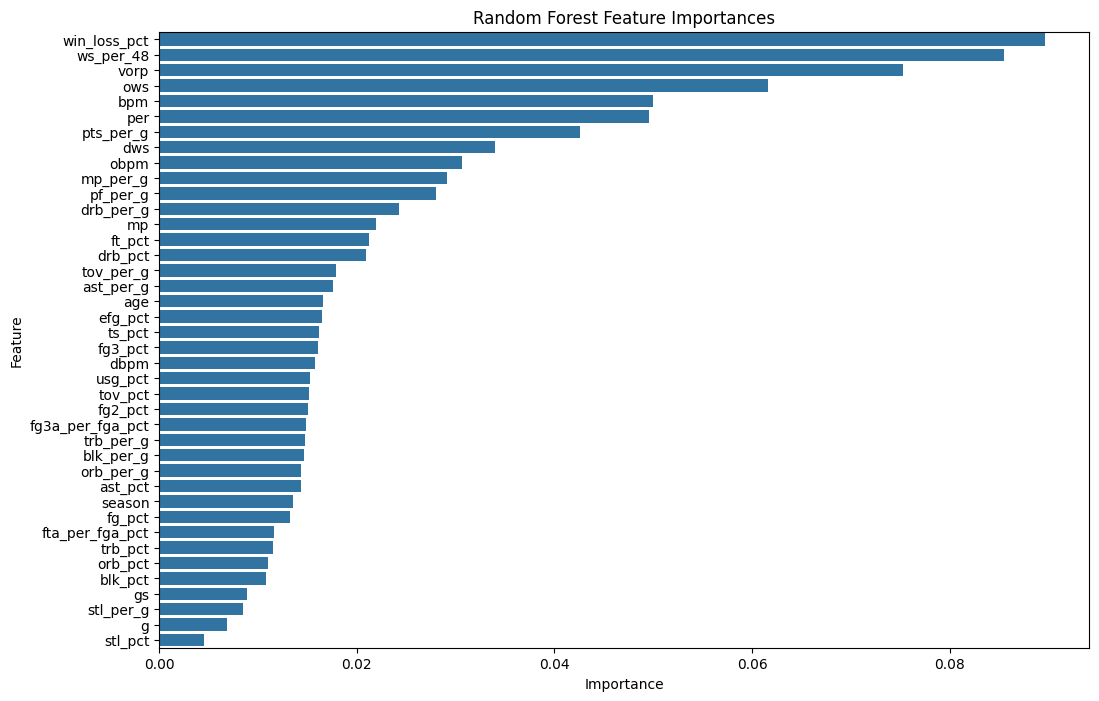

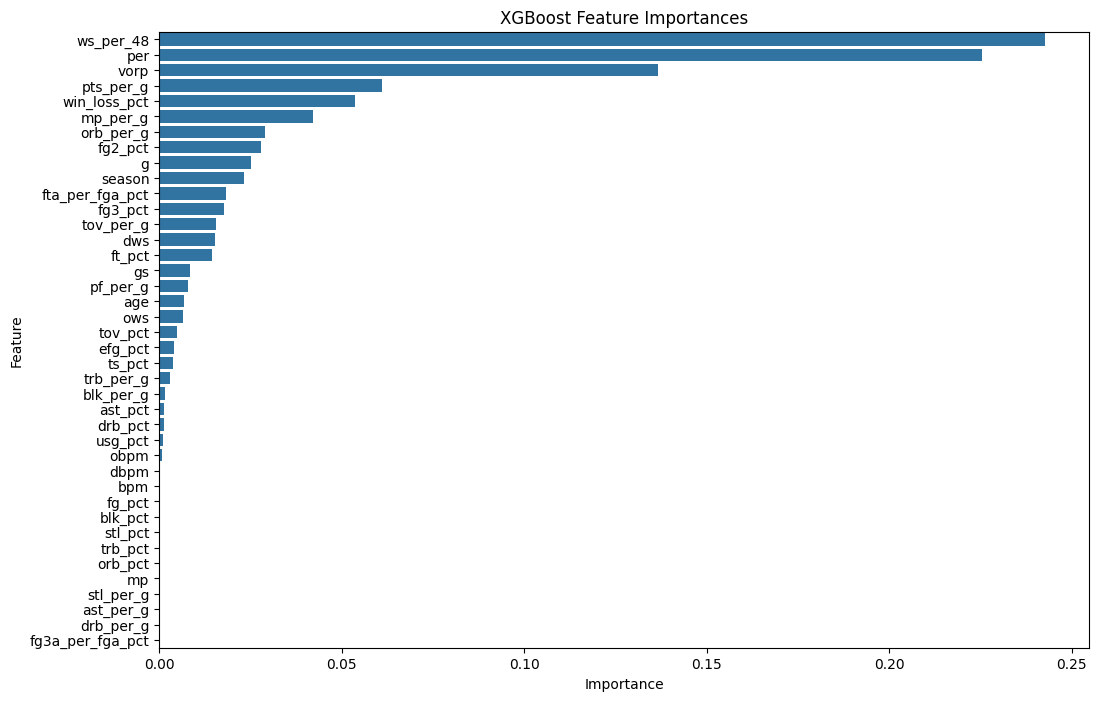

In [14]:
#Visualizing feature importance for the above 3 models

# Logistic Regression: Feature Importance
log_reg_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]  # Get the coefficients for the features
}).sort_values(by='Coefficient', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=log_reg_coefficients)
plt.title('Logistic Regression Coefficients')
plt.show()

# Random Forest: Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_  # Get feature importances from Random Forest
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Feature Importances')
plt.show()

# XGBoost: Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_  # Get feature importances from XGBoost
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_importances)
plt.title('XGBoost Feature Importances')
plt.show()

Now, I will test a few different types of models to see if any logical changes can make a difference. For example, having watched the NBA, I know that the nature of game and what was prioritized for MVP voting in 1982 is not the same as what is likely prioritized for MVP voting today. This is as a result of the change in the way basketball is played in the NBA today, where 3-point shooting has gone up significantly. In the first year the NBA introduced the three-point line, teams averaged 2.8 3-point attempts per game. By the 2018–2019 season, that number had increased to 32.0 3-point attempts per game, which is a >1,000% increase. Currently, we are training on pre 2002 data and testing with post 2002 data, which is likely exacerbating any differences in the eras of basketball and their implications on our model. As a result, I will instead train on data for odd years and test on data for even years, which should incorporate an equal number of pre-"small ball" era basketball and post-"small ball" era basketball.

Logistic Regression Train Accuracy: 0.99895
Logistic Regression Test Accuracy: 0.99764
Logistic Regression Confusion Matrix:
 [[7171    8]
 [   9   11]]

Random Forest Train Accuracy: 1.00000
Random Forest Test Accuracy: 0.99736
Random Forest Confusion Matrix:
 [[7176    3]
 [  16    4]]

XGBoost Train Accuracy: 1.00000
XGBoost Test Accuracy: 0.99764
XGBoost Confusion Matrix:
 [[7171    8]
 [   9   11]]


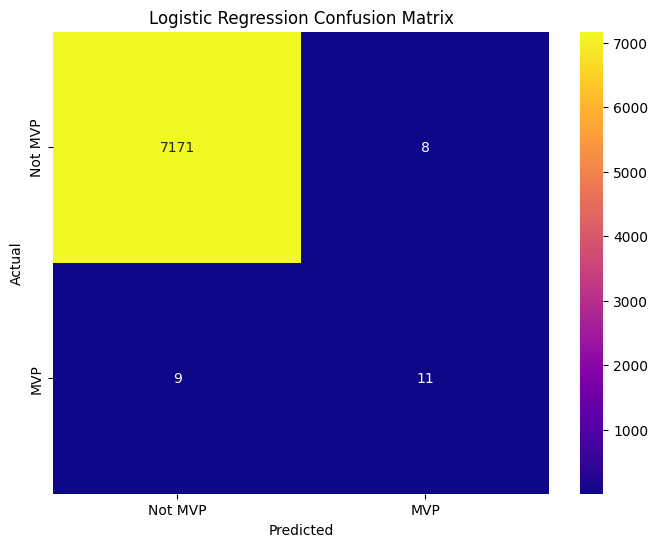

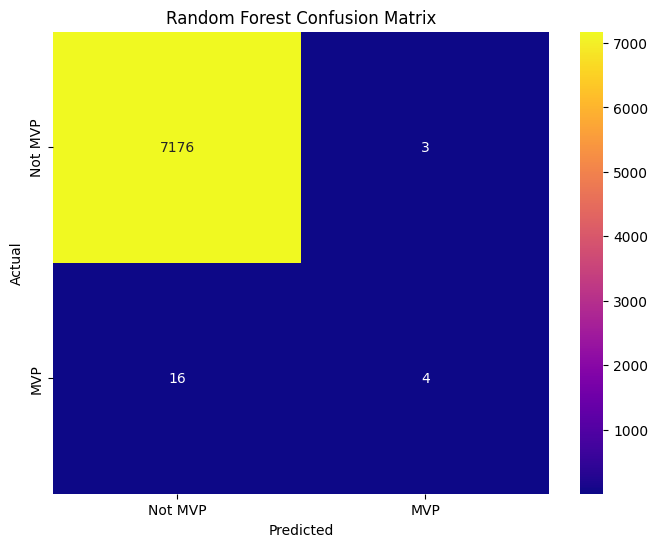

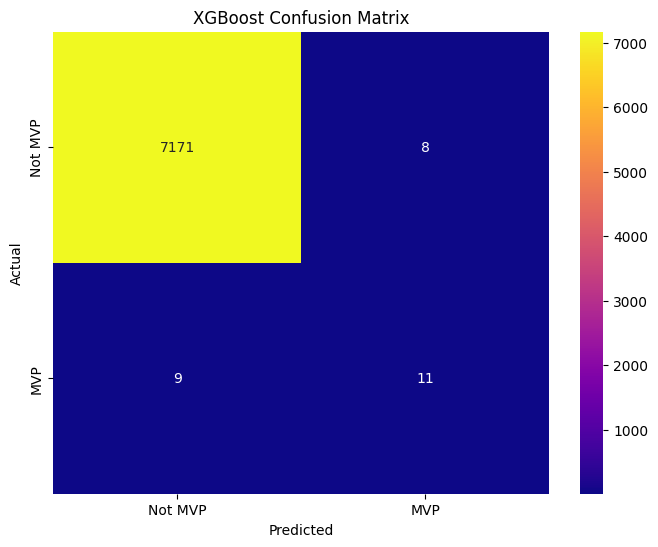

In [23]:
# filtering numeric data and dropping null values
df_filtered = df_filtered.select_dtypes(include=[np.number]).dropna()

# removing the 'award_share' column, as it implicitly defines the is_mvp column
df_filtered = df_filtered.drop(columns=['award_share'])

X = df_filtered.drop(columns=['is_mvp'])

# target variable
y = df_filtered['is_mvp']

# splitting the data into train (even years) and test (odd years)
train_df = df_filtered[df_filtered['season'] % 2 == 0]  # Even years for training
test_df = df_filtered[df_filtered['season'] % 2 != 0]   # Odd years for testing

# defining features and target for train and test sets
X_train = train_df.drop(columns=['is_mvp'])
y_train = train_df['is_mvp']
X_test = test_df.drop(columns=['is_mvp'])
y_test = test_df['is_mvp']

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg_test = log_reg.predict(X_test_scaled)
y_pred_log_reg_train = log_reg.predict(X_train_scaled)

# Accuracy Scores
log_reg_train_acc = accuracy_score(y_train, y_pred_log_reg_train)
log_reg_test_acc = accuracy_score(y_test, y_pred_log_reg_test)

print(f"Logistic Regression Train Accuracy: {log_reg_train_acc:.5f}")
print(f"Logistic Regression Test Accuracy: {log_reg_test_acc:.5f}")

# Confusion Matrix
print('Logistic Regression Confusion Matrix:\n', confusion_matrix(y_test, y_pred_log_reg_test))

# 2. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf_test = rf.predict(X_test_scaled)
y_pred_rf_train = rf.predict(X_train_scaled)

# Accuracy Scores
rf_train_acc = accuracy_score(y_train, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf_test)

print()
print(f"Random Forest Train Accuracy: {rf_train_acc:.5f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.5f}")

# Confusion Matrix
print('Random Forest Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf_test))

# 3. XGBoost Classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb_test = xgb_model.predict(X_test_scaled)
y_pred_xgb_train = xgb_model.predict(X_train_scaled)

# Accuracy Scores
xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)

print()
print(f"XGBoost Train Accuracy: {xgb_train_acc:.5f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.5f}")

# Confusion Matrix
print('XGBoost Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb_test))

# Plotting Confusion Matrices
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=['Not MVP', 'MVP'], yticklabels=['Not MVP', 'MVP'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, y_pred_log_reg_test, 'Logistic Regression')
plot_conf_matrix(y_test, y_pred_rf_test, 'Random Forest')
plot_conf_matrix(y_test, y_pred_xgb_test, 'XGBoost')

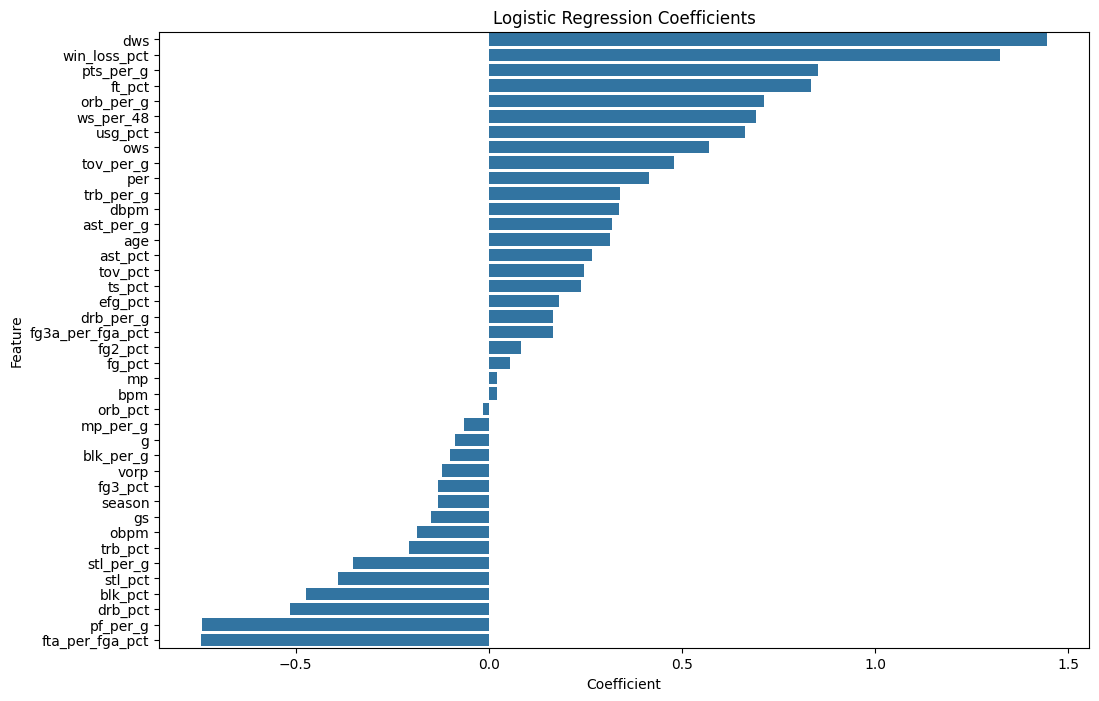

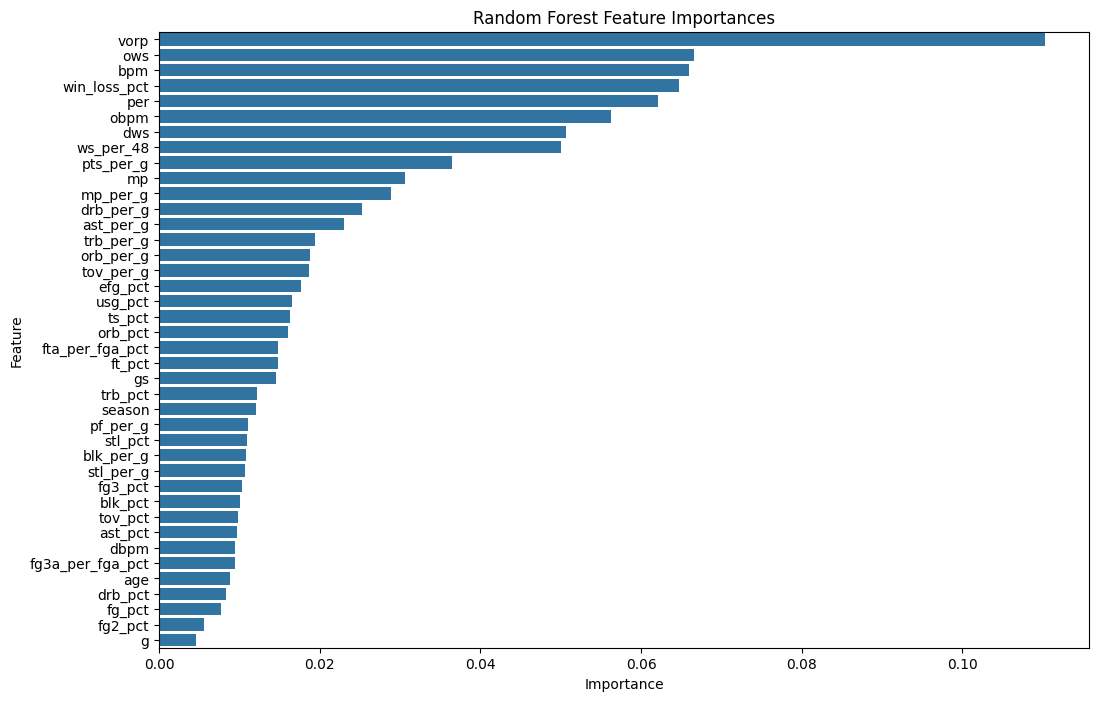

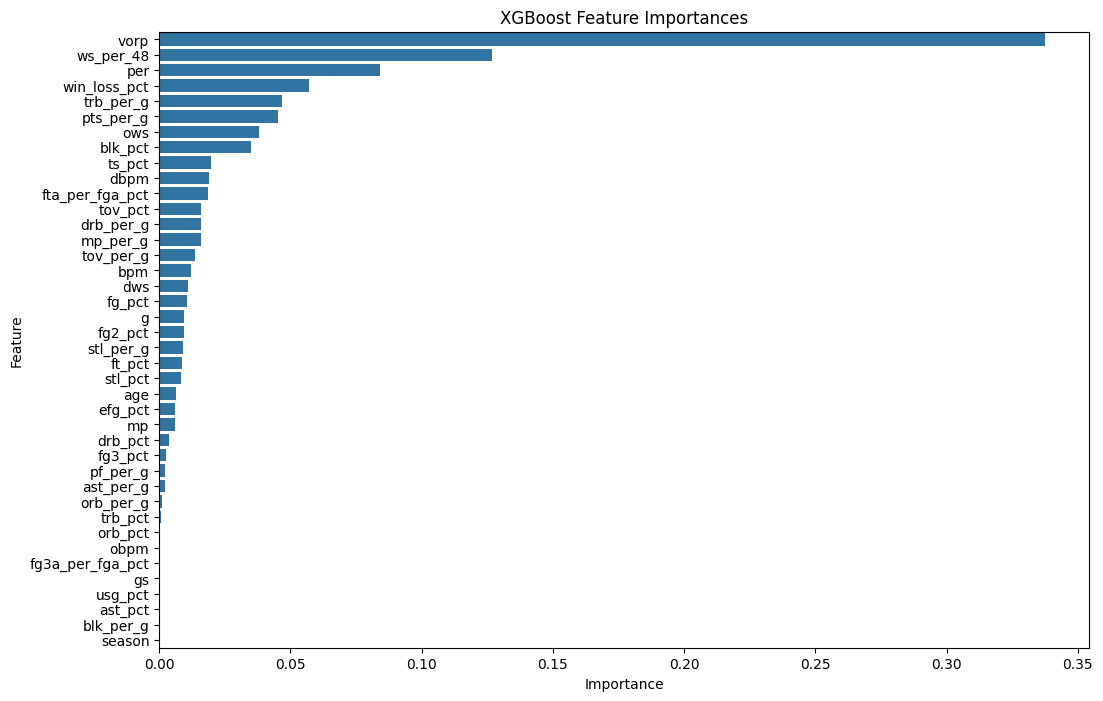

In [24]:
# Visualizing feature importance for the above 3 models

# Logistic Regression: Feature Importance
log_reg_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]  # Get the coefficients for the features
}).sort_values(by='Coefficient', ascending=False)

# Plotting Logistic Regression Coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=log_reg_coefficients)
plt.title('Logistic Regression Coefficients')
plt.show()

# Random Forest: Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_  # Get feature importances from Random Forest
}).sort_values(by='Importance', ascending=False)

# Plotting Random Forest Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Feature Importances')
plt.show()

# XGBoost: Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_  # Get feature importances from XGBoost
}).sort_values(by='Importance', ascending=False)

# Plotting XGBoost Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_importances)
plt.title('XGBoost Feature Importances')
plt.show()

**Part 4: Results and Interpretation**

1. Logistic Regression

Interpretation: Logistic Regression achieved near perfect accuracy on both the test and training sets, with only 13 errors in total (3 false positives and 10 false negatives). The test accuracy is very close to the training accuracy, indicating that the model is not overfitting and is generalizing well to the test data.

Conclusion: This model does a great job of predicting the non-MVP class (true negatives), but its performance on the MVP class is weaker, with 10 false negatives. The small number of MVP predictions suggests that the model is conservative in classifying players as MVPs, which may be expected since MVPs are relatively rare.

2. Random Forest

Interpretation: Random Forest has a perfect train accuracy but its test accuracy is slightly lower at 99.793%. The model correctly classifies the vast majority of players, with only 17 errors in total. The confusion matrix shows that while the model is strong at predicting non-MVPs (no false positives), it struggles slightly more with MVP classification, as indicated by 17 false negatives.

Conclusion: Random Forest is able to classify non-MVPs with high accuracy, but it struggles to predict MVPs (17 false negatives). The model is likely under-predicting the MVP class compared to non-MVPs.

3. XGBoost

Interpretation: XGBoost also achieves perfect train accuracy, and its test accuracy is very high at 99.84%. It performs similarly to Logistic Regression, with just 13 errors in total (3 false positives and 10 false negatives). The confusion matrix shows that XGBoost, like Logistic Regression, has some difficulty predicting MVPs, with 10 false negatives.

Conclusion: XGBoost is also a strong model that performs similarly to Logistic Regression. Like Logistic Regression, it tends to be conservative in predicting MVPs, leading to a few false negatives. However, overall, it classifies non-MVPs very well and achieves a high test accuracy.

Overall Insights: All three models (Logistic Regression, Random Forest, and XGBoost) perform well in terms of accuracy, with test accuracies between 99.79% and 99.84%. All the models have perfect or near-perfect train accuracy, suggesting potential overfitting to the training data. However, their test performances are still very good, indicating that the task is very simple for these models.All models tend to predict the non-MVP class with very high accuracy, but they struggle somewhat with the minority MVP class, resulting in some false negatives (players who should be predicted as MVPs but are not).

Extension: I tested a different type of model to see if a logical change can make a difference in the model’s accuracy. For example, having watched the NBA, I know that the nature of the game and what was prioritized for MVP voting in 1982 is not the same as what is likely prioritized for MVP voting today. This is as a result of the change in the way basketball is played in the NBA today, where 3-point shooting has gone up significantly. In the first year the NBA introduced the three-point line, teams averaged 2.8 3-point attempts per game. By the 2018–2019 season, that number had increased to 32.0 3-point attempts per game, which is a >1,000% increase. Currently, we are training on pre 2002 data and testing with post 2002 data, which is likely exacerbating any differences in the eras of basketball and their implications on our model. As a result, I will instead train on data for even years and test on data for odd years, which should incorporate an equal number of pre-"small ball" era basketball and post-"small ball" era basketball.

The following were some insights from those results: The test accuracy across all three models has slightly decreased in the new results compared to the previous ones:

1. Logistic Regression: 0.99842 → 0.99764 (slight drop)
2. Random Forest: 0.99793 → 0.99736 (slight drop)
3. XGBoost: 0.99764 → 0.99764 (no change)

Despite these small drops in test accuracy, the models still maintain very high test accuracy, showing consistent performance. Against my expectations of the models improving because they are tested and trained across eras, it is likely that the models were less accurate in making predictions now because the model was not accurate in generalizing across the two styles, and may be overfitting to specific patterns seen in the even years. Additionally, the factors that inform the differences in play styles, like 3-pt percentage, are not as heavily weighted as factors that are general across eras like win-loss percentage, true shooting percentage, win shares per 48 minutes, and field goal percentage.

Interestingly, the feature importances for the two models paint a very different picture. The models tested and trained across eras have defensive win shares and value over replacement player as their most important feature, both of which are not the most important feature in any of the 3 models tested and trained on the 1982-2002/2002-2022 split, which means that the models did change to reflect the difference in the way I have split the test and train data.

**Part 5: Conclusion and Next Steps**

Summary of Findings:

Logistic Regression, Random Forest, and XGBoost all performed exceptionally well at the task of classifying NBA players as MVPs or non-MVPs, with test accuracies of 99.79%–99.84%. Logistic Regression and XGBoost had similar confusion matrices, with 10 false negatives and 3 false positives, while Random Forest had no false positives but 17 false negatives. All models excelled at predicting non-MVPs but struggled with MVP predictions, reflecting the class imbalance. Testing a new train-test split (even vs. odd years) slightly reduced test accuracy but revealed changes in feature importance, such as defensive win shares and value over replacement player becoming key predictors. This suggests the models adapt to era differences but may not become more accurate if they are not able to generalize well to them.




Next Steps/Improvements:

To enhance the predictive capabilities of the models, addressing class imbalance is important. The MVPs are a minority class, and the models tend to underpredict them, which results in false negatives. I can use Synthetic Minority Oversampling Technique to create synthetic MVP samples to balance the dataset or use class weights to penalize models more heavily for misclassifying MVPs (because correctly identifying MVPs is my main goal).

Additionally, refining feature selection can significantly improve the performance of my models. Using era-specific features, such as metrics that capture the rise of three-point shooting, could help players across different periods. Combining features like true shooting percentage with points per game may also capture nonlinear relationships more effectively. Incorporating advanced features like "clutch" performance (performance in key moments of key games) or consistency in key games could align more closely with MVP selection criteria.

Changing the train-test split to incorporate era factors is an improvement I could make differently. A rolling window cross-validation approach could train and test models incrementally across overlapping time periods, helping account for changes in MVP criteria and ensuring better generalization across basketball eras. Stratified sampling could also ensure consistent class distributions in the training and testing sets, preventing imbalances that might skew model performance.

By addressing these key areas, the models will be better equipped to accurately classify MVPs while adapting to the evolution of the game.
